## Exploration of Image Transformations on RSNA Pneumonia Dataset


In [103]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from config import load_config
from rsna_dataloader import RSNAPneumoniaDataModule
from transforms_select import PREPROCESS_TRANSFORMS, TRAIN_TRANSFORMS, CONTRAST_TRANSFORMS, SALT_PEPPER_NOISE_TRANSFORMS

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
CONFIG_PATH = "config.yml"
configs = load_config(CONFIG_PATH)
NUM_IMAGES = configs["inference"]["predict_size"] = 8
IMG_INDICES = [0,1,2,3,4,5,6,7]
IMG_INDEX = 0

rsna = RSNAPneumoniaDataModule(configs)
predict_dataloader = rsna.predict_dataloader(IMG_INDICES, transforms.ToTensor())
original_imgs = next(iter(predict_dataloader))


def plot_images_for_one_transform(batch, title):
    fig, ax = plt.subplots(1, NUM_IMAGES, figsize=(NUM_IMAGES*2, 2.5))
    fig.suptitle(title)
    for i in range(NUM_IMAGES):
        img = batch["image"][i].squeeze().permute(1,2,0)
        ax[i].set_title("Label: " + str(batch["target"][i].item()))
        ax[i].imshow(img, cmap="gray")
        ax[i].axis("off")


def plot_transforms_for_one_image(rsna, transforms):
    num_transforms = len(transforms)
    fig, ax = plt.subplots(1, num_transforms, figsize=(num_transforms*2, 2.5))
    for i, (trans_name, transform) in enumerate(transforms.items()):
        dataloader = rsna.predict_dataloader([IMG_INDEX], transform)
        batch = next(iter(dataloader))
        img = batch["image"].squeeze().permute(1,2,0)
        ax[i].set_title(trans_name)
        ax[i].imshow(img, cmap="gray")
        ax[i].axis("off")


DISTRIBUTION LABEL BY GENDER
label_rsna_pneumonia     False     True 
Patient Gender                          
F                     0.782775  0.217225
M                     0.768561  0.231439
#train:  20412
#val:    2269
#test:   4003


### 1. Original Images From Test Set

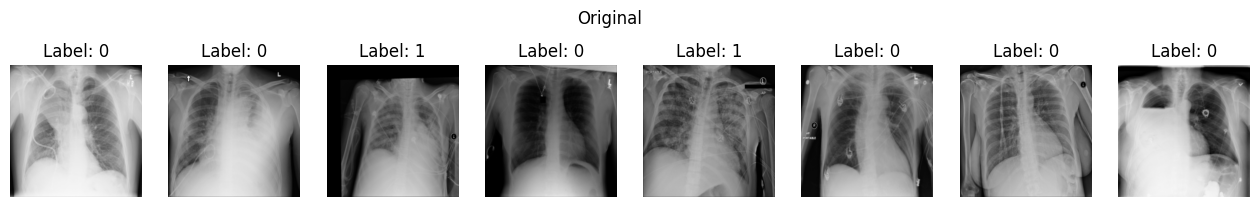

In [109]:
plot_images_for_one_transform(original_imgs, title="Original")

### 2. Preprocessing and Augmentation for Model Training

#### 2.1 Preprocessing: Resize + Center Crop
Resize to 256 then center crop to:
- Remove text along edges
- Focus more on lungs

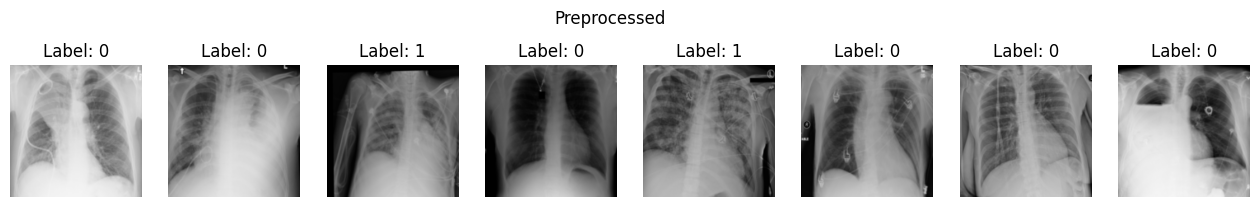

In [110]:
predict_dataloader = rsna.predict_dataloader(IMG_INDICES, PREPROCESS_TRANSFORMS)
preprocessed_imgs = next(iter(predict_dataloader))
plot_images_for_one_transform(preprocessed_imgs, title="Preprocessed")

#### 2.2 Augmentation: Rotation, Horizontal Flip, Resized Crop

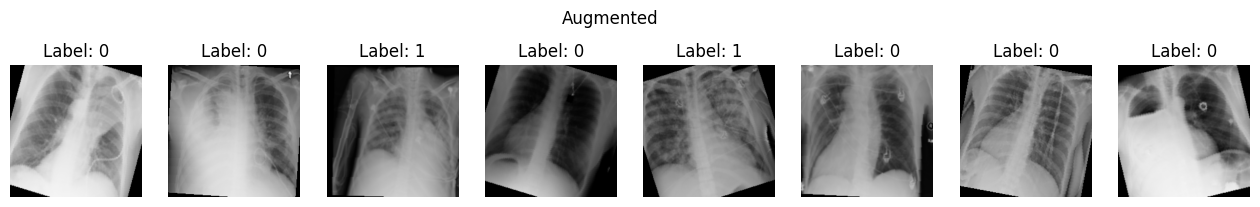

In [111]:
predict_dataloader = rsna.predict_dataloader(IMG_INDICES, TRAIN_TRANSFORMS)
augmented_imgs = next(iter(predict_dataloader))
plot_images_for_one_transform(augmented_imgs, title="Augmented")

### 3. Synthetic Data Shifts

#### 3.1 Contrast

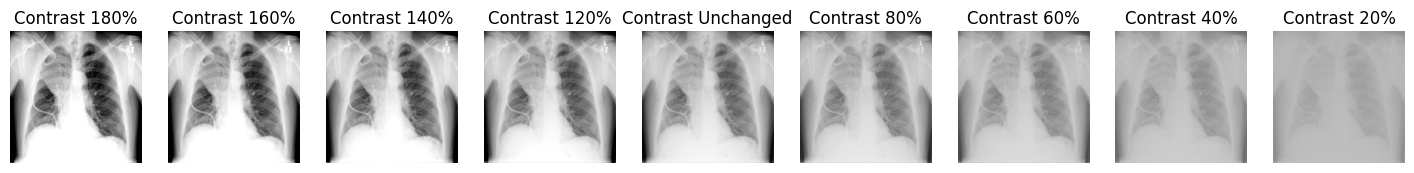

In [112]:
plot_transforms_for_one_image(rsna, CONTRAST_TRANSFORMS)

#### 3.2 Noise

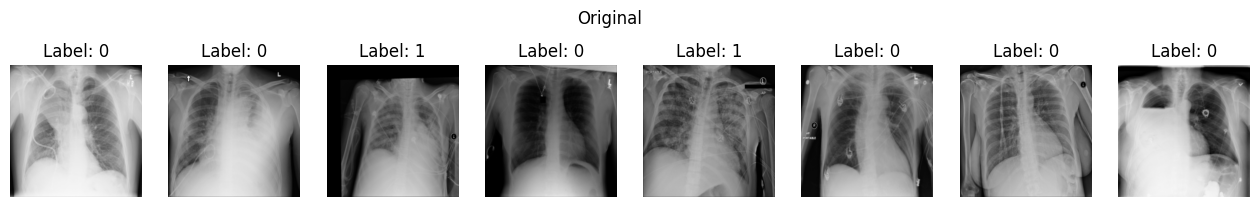

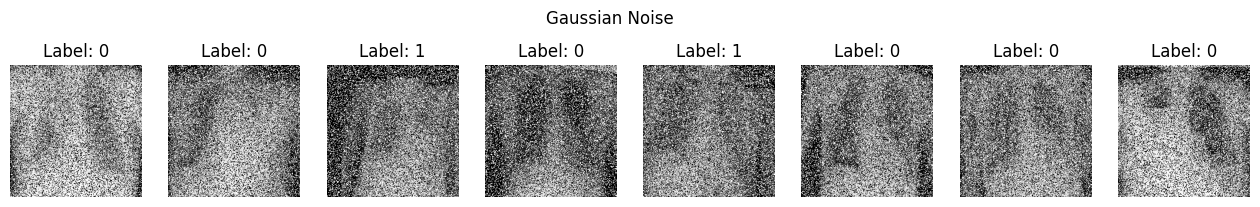

In [ ]:
plot_transforms_for_one_image(rsna, SALT_TRANSFORMS)


import numpy as np
from skimage.util import random_noise

class SaltPepperNoiseTransform:
    def __init__(self, percent):
        self.percent = percent
        
    def __call__(self, tensor):
       
        tensor = tensor[0,:,:]
        tensor = torch.tensor(random_noise(tensor, mode='s&p', salt_vs_pepper=0.5, clip=True, amount=0.5))
        tensor = tensor.expand(3,224, 224)

        return tensor


transform_gn = transforms.Compose([transforms.ToTensor(), SaltPepperNoiseTransform(percent=0.01)])
dataloader_gn  = rsna.predict_dataloader(IMG_INDICES, transform_gn)
gaussian_noise_imgs = next(iter(dataloader_gn))

plot(original_imgs, title="Original")
plot(gaussian_noise_imgs, title="Gaussian Noise")